# IS5126 Group 17
# Singapore second hand car valuation calculator




# Data Collection
Web Wrapping From Singapore Car Market Website
URL: https://www.sgcarmart.com/used_cars/info.php?ID={}&DL=1000

In [ ]:
#DONT'T RUN !!!!!!Unless Need More Data!
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
import requests
import time
import random
import csv

# Iterate over the range of car IDs to scrape and collect field names
all_fieldnames = set()
car_data_list = []

for ids in tqdm(range(1347910 - 5000, 1347910)):  # Adjust to the desired ID range (example shows 10 IDs)
    try:
        # Generate the target URL
        url_i = 'https://www.sgcarmart.com/used_cars/info.php?ID={}&DL=1000'.format(ids)
        resp = requests.get(url_i)
        sg_car_mart = bs(resp.text, 'html.parser')
        time.sleep(random.uniform(0.5, 1.5))  # Add random delay to avoid being blocked

        car_data = {}
        # Find the main container `main_left` with the car information table `carInfo`
        main_left = sg_car_mart.find('div', id='main_left')
        if main_left:
            car_info_table = main_left.find('table', id='carInfo')

            # Ensure the table was found
            if car_info_table:
                each_info_divs = car_info_table.find_all('div', class_='eachInfo')

                # Iterate over each `eachInfo` div to find specific information
                for each_info in each_info_divs:
                    row_title_div = each_info.find('div', class_='row_title')
                    row_info_div = each_info.find('div', class_='row_info')

                    # If both title and information were found
                    if row_title_div and row_info_div:
                        row_title = row_title_div.get_text(strip=True)
                        row_info = row_info_div.get_text(strip=True)
                        car_data[row_title] = row_info
                        all_fieldnames.add(row_title)

            # Find price information
            price_row = car_info_table.find_all('tr', class_='row_bg')[0]
            if price_row:
                price_label_td = price_row.find('td', class_='label')
                price_value_td = price_row.find('td', class_='font_red')
                if price_label_td and price_value_td:
                    price_label = price_label_td.get_text(strip=True)
                    price_value = price_value_td.get_text(strip=True)
                    car_data[price_label] = price_value
                    all_fieldnames.add(price_label)

            # Find depreciation information
            depreciation_row = car_info_table.find_all('tr', class_='row_bg')[1]
            if depreciation_row:
                depreciation_label_td = depreciation_row.find('td', class_='label')
                depreciation_value_td = depreciation_row.find('td', valign='top')
                if depreciation_label_td and depreciation_value_td:
                    depreciation_label = depreciation_label_td.get_text(strip=True)
                    depreciation_value = depreciation_value_td.get_text(strip=True)
                    car_data[depreciation_label] = depreciation_value
                    all_fieldnames.add(depreciation_label)

        # Find car description information
        rows = sg_car_mart.find_all('tr', class_='row_bg1')
        for row in rows:
            description_td = row.find('td', colspan='4')
            if description_td:
                # Find `twoRow_info` div and its following text
                two_row_info_div = description_td.find('div', class_='twoRow_info')
                if two_row_info_div:
                    strong_tag = two_row_info_div.find('strong')
                    if strong_tag:
                        key = strong_tag.get_text(strip=True)
                        description_text = description_td.get_text(strip=True)
                        car_data[key] = description_text
                        all_fieldnames.add(key)

        # Find brand information
        brand_div = sg_car_mart.find('a', class_='nounderline globaltitle')
        if brand_div:
            brand = brand_div.get_text(strip=True)
            car_data['Brand'] = brand
            all_fieldnames.add('Brand')

        # If car_data is not empty, collect the car data
        if car_data:
            car_data_list.append(car_data)

    except Exception as e:
        print(f"Failed to process ID {ids}: {e}")
        continue

# Write to CSV file
with open('./Project/car_data.csv', mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=list(all_fieldnames))
    writer.writeheader()
    for car_data in car_data_list:
        writer.writerow(car_data)


# Data Preprocessing

In [4]:
# import car_data.csv from google drive

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Assuming your CSV file is in '/content/drive/MyDrive/IS5126_final/'
# Replace with the actual path to your file in Google Drive
file_path = '/content/drive/MyDrive/IS5126_final/car_data_copy.csv'

try:
  car_data_raw = pd.read_csv(file_path)
  print(car_data_raw.info())
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the path.")
except pd.errors.ParserError:
    print(f"Error: Could not parse the CSV file at {file_path}.  Please check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19334 entries, 0 to 19333
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Features          18663 non-null  object
 1   Description       18292 non-null  object
 2   COE               19334 non-null  object
 3   Price             19317 non-null  object
 4   Dereg Value       19334 non-null  object
 5   Manufactured      18703 non-null  object
 6   No. of Owners     19300 non-null  object
 7   Status            19334 non-null  object
 8   Category          19334 non-null  object
 9   Fuel Type         4321 non-null   object
 10  Type of Vehicle   2497 non-null   object
 11  Additional        116 non-null    object
 12  Curb Weight       19334 non-null  object
 13  Depreciation      19334 non-null  object
 14  OMV               193

### Data Cleaning Preproessing Steps for Car Data

1. **Replace 'N.A' values with NaN**: The function `clean_na_values` replaces any occurrences of `'N.A'` or `'N.A.'` with `NaN` to standardize missing values.

2. **Drop columns with a high percentage of missing values**: The function `drop_high_null_columns` removes columns where the percentage of missing values exceeds the specified `null_threshold` (default is 90%).

3. **Clean text columns**: The function `clean_text_columns` removes redundant prefixes (e.g., "Category", "Description", "Features") from the start of values in specific text columns, if they exist.

4. **Drop rows with missing values in critical columns**: The function `drop_invalid_rows` removes rows with missing values in critical columns such as `Mileage`, `Road Tax`, `ARF`, `Brand`, `No. of Owners`, `COE`, `Manufactured`, and `OMV`.

5. **Drop duplicate rows**: The function `drop_duplicates` removes any duplicate rows in the dataset.

6. **Clean currency columns**: The function `clean_currency_columns` removes currency symbols (e.g., `$`) and commas from columns like `COE`, `Price`, `ARF`, and `OMV`, and converts these columns to numeric types.

7. **Clean and rename the 'Road Tax' column**: The function `clean_road_tax_column` removes currency symbols and units (`$/yr`) from the `Road Tax` column and renames it to `Road Tax (per year)` for clarity.

8. **Extract mileage information**: The function `extract_mileage` extracts the total mileage and the yearly mileage (in kilometers) from the `Mileage` column, creating new columns `Total Mileage` and `Mileage per year`, then drops the original `Mileage` column.

9. **Drop unnecessary columns**: The function `drop_unnecessary_columns` removes columns that are not needed for analysis, such as `Status` and `Resources`.

10. **Execute all preprocessing steps**: The function `preprocess_car_data` calls each of the above functions in sequence to perform the complete preprocessing pipeline.

After running the `preprocess_car_data` function, the dataset `car_data_preprocessed` will be clean and ready for analysis or model training.



In [5]:

import pandas as pd
import numpy as np
import re

def clean_na_values(df):
    df.replace(['N.A', 'N.A.'], np.nan, inplace=True)
    return df

def drop_high_null_columns(df, null_threshold=0.9):
    null_percentage = df.isnull().sum() / len(df)
    columns_to_drop = null_percentage[null_percentage > null_threshold].index
    df.drop(columns=columns_to_drop, inplace=True)
    return df

def clean_text_columns(df):
    if 'Category' in df.columns:
        df['Category'] = df['Category'].str.replace(r'^Category', '', regex=True).str.strip()
    if 'Description' in df.columns:
        df['Description'] = df['Description'].str.replace(r'^Description', '', regex=True).str.strip()
    if 'Features' in df.columns:
        df['Features'] = df['Features'].str.replace(r'^Features', '', regex=True).str.strip()
    return df

def drop_invalid_rows(df):
    """
    Drop rows with NaN values in critical columns.
    """
    columns_to_check = [
        'Mileage', 'RoadTax', 'ARF', 'Brand',
        'No. of Owners', 'COE', 'Manufactured', 'OMV'
    ]
    df.dropna(subset=[col for col in columns_to_check if col in df.columns], inplace=True)
    return df


def drop_duplicates(df):
    df.drop_duplicates(inplace=True)
    return df

def clean_currency_columns(df):
    currency_cols = ['COE', 'Price', 'ARF', 'OMV']
    for col in currency_cols:
        if col in df.columns:
            df[col] = df[col].replace('[\$,]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def clean_road_tax_column(df):
    if 'Road Tax' in df.columns:
        df['Road Tax'] = df['Road Tax'].replace('[\$/yr,]', '', regex=True)
        df['Road Tax'] = pd.to_numeric(df['Road Tax'], errors='coerce')
        df.rename(columns={'Road Tax': 'Road Tax (per year)'}, inplace=True)
    return df

def extract_mileage(df):
    if 'Mileage' in df.columns:
        df['Total Mileage'] = df['Mileage'].str.extract(r'(\d[\d,]*)')[0].replace(',', '', regex=True).astype(float)
        df['Mileage per year'] = df['Mileage'].str.extract(r'\((\d+\.?\d*)k /yr\)')[0].astype(float) * 1000
        df.drop(columns=['Mileage'], inplace=True)
    return df

def drop_unnecessary_columns(df):
    columns_to_drop = ['Status', 'Resources']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    return df

def preprocess_car_data(df, null_threshold=0.9):
    df = clean_na_values(df)
    df = drop_high_null_columns(df, null_threshold)
    df = clean_text_columns(df)
    df = drop_invalid_rows(df)
    df = drop_duplicates(df)
    df = clean_currency_columns(df)
    df = clean_road_tax_column(df)
    df = extract_mileage(df)
    df = drop_unnecessary_columns(df)
    return df




In [6]:
car_data_preprocessed = preprocess_car_data(car_data_raw)

print(car_data_preprocessed.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7436 entries, 2 to 19333
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Features             7286 non-null   object 
 1   Description          7292 non-null   object 
 2   COE                  7435 non-null   float64
 3   Price                7427 non-null   float64
 4   Dereg Value          7406 non-null   object 
 5   Manufactured         7436 non-null   object 
 6   No. of Owners        7436 non-null   object 
 7   Category             7436 non-null   object 
 8   Fuel Type            1493 non-null   object 
 9   Type of Vehicle      1170 non-null   object 
 10  Curb Weight          7411 non-null   object 
 11  Depreciation         7326 non-null   object 
 12  OMV                  7435 non-null   float64
 13  Brand                7436 non-null   object 
 14  Road Tax (per year)  7103 non-null   float64
 15  Power                7089 non-null   objec

In [7]:
car_data_preprocessed

,Features,Description,COE,Price,Dereg Value,Manufactured,No. of Owners,Category,Fuel Type,Type of Vehicle,...,Depreciation,OMV,Brand,Road Tax (per year),Power,Engine Cap,Transmission,ARF,Total Mileage,Mileage per year
2,Grey exterior with brown interior. Comes with ...,1 owner with very low mileage! C&C unit! Everg...,31302.0,130800.0,"$62,939 as of today (change)",2018,1,"PARF Car,Premium Ad Car,Low Mileage Car",NaN,NaN,...,"$23,310 /yrView models with similar depre",55386.0,Mercedes-Benz E-Class E200 Avantgarde,1202.0,135.0 kW (181 bhp),"1,991 cc",Auto,71695.0,52000.0,8800.0
4,"2.0L DOHC 16V Engine, Cruise Control, SRS Airb...",Most affordable luxury car in the market! Rare...,50932.0,13800.0,"$7,256 as of today (change)",2006,1,"COE Car,Direct Owner Sale,Low Mileage Car",NaN,NaN,...,"$9,690 /yr",24434.0,Nissan Cefiro 2.0A (COE till 03/2026),1815.0,107.0 kW (143 bhp),"1,998 cc",Auto,26878.0,108420.0,5800.0
9,1.6l reliable 4 cylinders inline 16-valves DOH...,Low mileage done. Most reliable car. 100% loan...,31976.0,52800.0,"$16,575 as of today (change)",2009,3,"COE Car,Low Mileage Car",NaN,NaN,...,"$10,190 /yr",17853.0,Toyota Corolla Altis 1.6A (COE till 12/2029),1113.0,80.0 kW (107 bhp),"1,598 cc",Auto,17853.0,146000.0,9900.0
10,V8 Twin-Turbocharged Engine With 7-speed (A) F...,1 owner lowest mileage showroom condition. Ful...,110003.0,1290800.0,"$551,348 as of today (change)",2022,1,"PARF Car,Rare & Exotic,Low Mileage Car",NaN,NaN,...,"$126,620 /yrView models with similar depre",309823.0,Ferrari F8 Spider,3796.0,530.0 kW (710 bhp),"3,902 cc",Auto,621611.0,1150.0,500.0
11,"1.6l 4-cylinder MIVEC engine, 4 speed auto tra...","Low mileage done of 85000km only, no engine mo...",51106.0,37800.0,"$20,894 as of today (change)",2017,2,"PARF Car,Premium Ad Car",NaN,NaN,...,"$11,530 /yrView models with similar depre",10927.0,Mitsubishi Lancer EX 1.6A,738.0,86.0 kW (115 bhp),"1,590 cc",Auto,10927.0,85000.0,11800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19325,3.5L V6 engine producing 311bhp and 380nm of t...,"Flawless conditions, agent service record, hig...",56089.0,79800.0,"$60,057 as of today (change)",2015,2,PARF Car,NaN,NaN,...,"$19,720 /yrView models with similar depre",66456.0,Lexus GS350 Luxury,3100.0,232.0 kW (311 bhp),"3,456 cc",Auto,91621.0,95000.0,11500.0
19326,Honda 1.3L Earth Dreams 4 cylinders I-VTEC eng...,As good as new compact Hatchback suitable for ...,16399.0,58800.0,"$10,972 as of today (change)",2018,1,"PARF Car,Premium Ad Car",NaN,NaN,...,"$12,950 /yrView models with similar depre",15539.0,Honda Fit 1.3A GF,578.0,73.0 kW (97 bhp),"1,317 cc",Auto,5539.0,95878.0,16900.0
19329,Original Condition. View specs of theBMW 1 Ser...,(Showroom Ready Stock!) As Good As New With Le...,105000.0,152800.0,"$99,491 as of today (change)",2022,1,"PARF Car,Premium Ad Car,Low Mileage Car",NaN,NaN,...,"$15,970 /yrView models with similar depre",31182.0,BMW 1 Series 116i Sportline,684.0,80.0 kW (107 bhp),"1,499 cc",Auto,20655.0,2113.0,1900.0
19331,View specs of theNissan Qashqai (2014-2020),Perfect car for daily usage. Ideal for short t...,50789.0,35800.0,"$20,508 as of today (change)",2016,2,PARF Car,NaN,NaN,...,"$11,980 /yrView models with similar depre",18725.0,Nissan Qashqai 1.2A DIG-T,508.0,85.0 kW (113 bhp),"1,197 cc",Auto,13725.0,115000.0,15200.0


### Car Data Preprocessing Pipeline

This pipeline preprocesses the car data through a series of steps, including feature extraction, column transformations, and multi-label encoding, to prepare it for analysis or machine learning tasks.

1. **Split Brand Column**:
   - The `Brand` column is split into `Car Brand` and `Car Model` for better granularity.

2. **Extract Engine Features**:
   - Custom functions extract `Engine Capacity` (e.g., "1.6L") and `Engine Type` (e.g., "V6", "DOHC") from the `Features` column.

3. **Clean Car Model**:
   - Any text within parentheses in the `Car Model` column is removed to standardize the model names.

4. **Process Category Column**:
   - The `Category` column is transformed into a list format for easier manipulation.
   - Categories with a frequency below a specified threshold (`min_count`, default 20) are filtered out.
   - Rows without valid categories are assigned a default `Other` category.

5. **One-Hot Encoding for Categories**:
   - Multi-label one-hot encoding is applied to the `Category` column using `MultiLabelBinarizer`.
   - The resulting binary encoding is combined into a single multi-label column `Category_Multilabel` for compact representation.

6. **Output**:
   - The function returns the processed DataFrame, `car_data_processed`, and a list of category classes, `category_classes`.

This pipeline provides a clean and structured dataset ready for further data analysis and model building.


In [5]:
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer

def preprocess_car_data(df, min_count=20):
    df[['Car Brand', 'Car Model']] = df['Brand'].str.split(' ', n=1, expand=True)
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

    def extract_engine_capacity(text):
        if pd.isnull(text):
            return None
        match = re.search(r'(\d+\.\d+L)', str(text), re.IGNORECASE)
        return match.group(1) if match else None

    def extract_engine_type(text):
        if pd.isnull(text):
            return None
        engine_types = ['DOHC', 'SOHC', 'V6', 'V8', '4-cylinder', '6-cylinder', 'Inline 4', 'Inline 6']
        for engine_type in engine_types:
            if engine_type.lower() in str(text).lower():
                return engine_type
        return None

    cols = ['Car Brand', 'Car Model'] + [col for col in df.columns if col not in ['Car Brand', 'Car Model']]
    df = df[cols]

    df['Engine Capacity'] = df['Features'].apply(extract_engine_capacity)
    df['Engine Type'] = df['Features'].apply(extract_engine_type)
    df['Car Model'] = df['Car Model'].str.replace(r'\s*\(.*?\)', '', regex=True)
    df.drop(columns=['Brand'], inplace=True)

    df['Category'] = df['Category'].fillna('').apply(lambda x: [cat.strip() for cat in x.split(',') if cat.strip()])
    category_counts = df['Category'].explode().value_counts()
    print("Category counts:\n", category_counts)

    valid_categories = category_counts[category_counts >= min_count].index.tolist()
    df['Category'] = df['Category'].apply(lambda x: [cat for cat in x if cat in valid_categories])
    df['Category'] = df['Category'].apply(lambda x: x if x else ['Other'])

    print(valid_categories)

    mlb = MultiLabelBinarizer()
    category_encoded = mlb.fit_transform(df['Category'])
    df['Category_Multilabel'] = [''.join(map(str, row)) for row in category_encoded]

    return df, mlb.classes_

car_data_processed, category_classes = preprocess_car_data(car_data_preprocessed, min_count=20)
print("Category classes:", category_classes)


Category counts:
 Category
PARF Car                   5962
Premium Ad Car             3761
Low Mileage Car            1864
COE Car                    1175
Hybrid Cars                 795
Direct Owner Sale           630
Sgcarmart Warranty Cars     572
Almost New Car              257
Rare & Exotic               213
Electric Cars               157
Consignment Car             150
-                            79
OPC Car                      48
Imported Used Vehicle        39
STA Evaluated Car            16
Vintage Cars                  6
Auction Vehicle               2
Name: count, dtype: int64
['PARF Car', 'Premium Ad Car', 'Low Mileage Car', 'COE Car', 'Hybrid Cars', 'Direct Owner Sale', 'Sgcarmart Warranty Cars', 'Almost New Car', 'Rare & Exotic', 'Electric Cars', 'Consignment Car', '-', 'OPC Car', 'Imported Used Vehicle']
Category classes: ['-' 'Almost New Car' 'COE Car' 'Consignment Car' 'Direct Owner Sale'
 'Electric Cars' 'Hybrid Cars' 'Imported Used Vehicle' 'Low Mileage Car'
 'OPC 

### NLP Feature Extraction for Car Data Descriptions

This code performs natural language processing on the `Description` column in the car data, extracting various NLP features to enhance data analysis.

1. **Text Cleaning**:
   - Converts the description text to lowercase for uniformity.

2. **Sentiment Analysis**:
   - Calculates the overall sentiment polarity score for each description using `TextBlob`.
   - Computes the average sentiment polarity of individual words to capture word-level sentiment information.

3. **Word and Adjective Counts**:
   - Uses spaCy to tokenize the text and count the total number of words and adjectives.

4. **Sentence Length**:
   - Measures the length of each description by character count.

5. **Stop Word Count**:
   - Counts the number of stop words in each description using NLTK’s English stop words list.

6. **Feature Integration**:
   - Each extracted feature is stored in a new column in the DataFrame.
   - The final DataFrame `car_data_processed_nlp` contains the original data along with the new NLP features, ready for further analysis or modeling.


In [6]:
import spacy
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def clean_text(text):
    text = text.lower()
    return text

def analyze_description(description):
    text_cl = clean_text(description)
    if len(text_cl) == 0:
        print(len(text_cl))

    blob = TextBlob(text_cl)
    sentiment_score = blob.sentiment.polarity
    word_sentiments = [TextBlob(word).sentiment.polarity for word in text_cl.split() if word.isalpha()]
    avg_word_sentiment = sum(word_sentiments) / len(word_sentiments) if word_sentiments else 0

    doc = nlp(text_cl)
    word_count = len([token.text for token in doc if token.is_alpha])
    adj_count = len([token for token in doc if token.pos_ == "ADJ"])
    sentence_length = len(text_cl)
    stop_words = stopwords.words('english')
    stop_word_count = len([token.text for token in doc if token.text.lower() in stop_words])

    return pd.Series({
        'Sentiment_Score': sentiment_score,
        'Avg_Word_Sentiment': avg_word_sentiment,
        'Word_Count': word_count,
        'Adjective_Count': adj_count,
        'Sentence_Length': sentence_length,
        'Stop_Word_Count': stop_word_count
    })

car_data_processed['Description'] = car_data_processed['Description'].astype(str)
results = car_data_processed['Description'].apply(analyze_description)
car_data_processed_nlp = car_data_processed.join(pd.DataFrame(results))

print(car_data_processed_nlp.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0
        Car Brand                Car Model  \
2   Mercedes-Benz  E-Class E200 Avantgarde   
4          Nissan              Cefiro 2.0A   
9          Toyota       Corolla Altis 1.6A   
10        Ferrari                F8 Spider   
11     Mitsubishi           Lancer EX 1.6A   

                                             Features  \
2   Grey exterior with brown interior. Comes with ...   
4   2.0L DOHC 16V Engine, Cruise Control, SRS Airb...   
9   1.6l reliable 4 cylinders inline 16-valves DOH...   
10  V8 Twin-Turbocharged Engine With 7-speed (A) F...   
11  1.6l 4-cylinder MIVEC engine, 4 speed auto tra...   

                                          Description       COE      Price  \
2   1 owner with very low mileage! C&C unit! Everg...   31302.0   130800.0   
4   Most affordable luxury car in the market! Rare...   50932.0    13800.0   
9   Low mileage done. Most reliable car. 100% loan...   31976.0    52800.0   
10  1 owner lowest mileage showroom condition. Ful...  110003.0  1

In [7]:
car_data_processed_nlp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7436 entries, 2 to 19333
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Car Brand            7436 non-null   object 
 1   Car Model            7435 non-null   object 
 2   Features             7286 non-null   object 
 3   Description          7436 non-null   object 
 4   COE                  7435 non-null   float64
 5   Price                7427 non-null   float64
 6   Dereg Value          7406 non-null   object 
 7   Manufactured         7436 non-null   object 
 8   No. of Owners        7436 non-null   object 
 9   Category             7436 non-null   object 
 10  Fuel Type            1493 non-null   object 
 11  Type of Vehicle      1170 non-null   object 
 12  Curb Weight          7411 non-null   object 
 13  Depreciation         7326 non-null   object 
 14  OMV                  7435 non-null   float64
 15  Road Tax (per year)  7103 non-null   float

### Car Data Enhancement using OpenAI API for Missing Values

This script enhances a car dataset by filling in missing values for specific attributes. It uses the OpenAI API to fetch detailed specifications based on the car's brand and model, ensuring that values adhere to predefined categories.

1. **Define Allowed Values for Categorical Columns**:
   - Sets the allowed values for `Transmission`, `Engine Type`, `Type of Vehicle`, and `Fuel Type` to ensure consistency in the data.

2. **Feature Extraction Functions**:
   - **extract_power**: Extracts and returns the numeric value from a power specification.
   - **extract_engine_capacity**: Extracts and returns the numeric part of the engine capacity.

3. **Fill Missing Values**:
   - The main function, `fill_missing_values`, identifies rows with missing values in specified columns and fetches data from OpenAI’s API.

4. **Fetch Car Information**:
   - **fetch_car_info**: Sends a prompt to OpenAI's ChatCompletion API, requesting detailed specifications based on the brand and model. The prompt includes constraints to ensure values match the allowed categories.

5. **Parse API Response**:
   - **parse_car_info**: Parses the response text from OpenAI into a dictionary, extracting numeric values and matching categorical values against the allowed options.

6. **Process Rows Concurrently**:
   - The function `process_row` fetches data for each row (using car brand and model) and updates the DataFrame with retrieved information.
   - `ThreadPoolExecutor` is used to handle concurrent requests to the API, optimizing processing speed.

7. **Update DataFrame**:
   - After fetching and parsing the data, the DataFrame is updated with the retrieved values, replacing any existing values in the specified columns.

8. **Usage**:
   - `fill_missing_values` is applied to the `car_data_processed_nlp` DataFrame to fill in missing values.
   - Finally, the updated dataset is displayed to verify the enhancements.

This approach ensures the car dataset is complete and standardized, with consistent values across key attributes, ready for further analysis.


In [1]:
pip install openai==0.28

In [12]:
pip install config

In [2]:
from google.colab import drive
import openai
import sys

drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/IS5126_final/config.py')

import config

openai.api_key = config.OPENAI_API_KEY
# openai.api_key = ''
models = openai.Model.list()

for model in models['data']:
    print(model['id'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
gpt-4o-mini-2024-07-18
text-embedding-ada-002
text-embedding-3-small


In [ ]:
import openai
import pandas as pd
import concurrent.futures
import re

# Updated allowed values for categorical columns
allowed_values = {
    'Transmission': ['Auto', 'Manual'],
    'Engine Type': ['DOHC', 'SOHC', 'V6', 'V8', 'Inline 4', 'Inline 6', 'Inline 3', 'Flat 4', 'Flat 6', 'Rotary'],
    'Type of Vehicle': ['Mid-Sized Sedan', 'Luxury Sedan', 'Hatchback', 'MPV',
                        'SUV', 'Sports Car', 'Stationwagon', 'Diesel Car',
                        'Hybrid Car', 'Electric Car', 'Truck', 'Bus/Mini Bus',
                        'Van', 'Vintage Car'],
    'Fuel Type': ['Petrol', 'Diesel', 'Petrol-Electric', 'Diesel-Electric', 'Electric']
}

def extract_power(value):
    """
    Extracts and returns the numeric part of the power.
    """
    try:
        numeric_value = re.findall(r'\d+', value)[0]
        return int(numeric_value)
    except IndexError:
        return None

def extract_engine_capacity(value):
    """
    Extracts and returns the numeric part of the engine capacity.
    """
    try:
        numeric_value = re.findall(r'\d+\.\d+|\d+', value)[0]
        return float(numeric_value)
    except IndexError:
        return None

def fill_missing_values(df):
    """
    Fill missing values in specified columns using OpenAI API.
    Processes the entire DataFrame and replaces existing values if new data is available.
    """
    columns_to_fill = list(allowed_values.keys()) + ['Power', 'Engine Capacity']

    # Define rows to process (all rows with missing values in specified columns)
    rows_to_process = [
        (index, row['Car Brand'], row['Car Model']) for index, row in df.iterrows()
        if pd.isnull(row[columns_to_fill]).any()
    ]

    def fetch_car_info(brand, model):
        """
        Fetch car information based on brand and model using OpenAI's ChatCompletion interface.
        """
        prompt = f"""
        Please provide the detailed specifications of the following car:
        - Brand: {brand}
        - Model: {model}

        The specifications should match the following allowed values:
        1. Power (e.g., any numeric value)
        2. Engine Capacity (e.g., any numeric value like 1.5, 2.0, etc.)
        3. Engine Type: {', '.join(allowed_values['Engine Type'])}
        4. Transmission: {', '.join(allowed_values['Transmission'])}
        5. Type of Vehicle: {', '.join(allowed_values['Type of Vehicle'])}
        6. Fuel Type: {', '.join(allowed_values['Fuel Type'])}

        Ensure that each specification matches one of the allowed values exactly where applicable.
        """

        try:
            response = openai.ChatCompletion.create(
                model="gpt-4o-mini-2024-07-18",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ]
            )
            content = response['choices'][0]['message']['content']

            car_info_dict = parse_car_info(content)
            return car_info_dict
        except Exception as e:
            print(f"Error fetching car info for {brand} {model}: {e}")
            return None

    def parse_car_info(response_text):
        """
        Parse the response text from OpenAI API into a dictionary.
        """
        car_info_dict = {}
        lines = response_text.split('\n')
        for line in lines:
            if ':' in line:
                key, value = line.split(':', 1)
                key = key.strip().lower()
                value = value.strip()

                # Normalize numerical values
                if "power" in key:
                    car_info_dict['Power'] = extract_power(value)
                elif "engine capacity" in key:
                    car_info_dict['Engine Capacity'] = extract_engine_capacity(value)

                # Normalize categorical values
                for col, options in allowed_values.items():
                    if col.lower() in key:
                        matched_value = next((opt for opt in options if opt.lower() in value.lower()), None)
                        if matched_value:
                            car_info_dict[col] = matched_value
        return car_info_dict

    def process_row(index, brand, model):
        if pd.isnull(brand) or pd.isnull(model):
            return None
        car_info_dict = fetch_car_info(brand, model)
        if car_info_dict:
            print(f"Fetched info for {brand} {model}: {car_info_dict}")  # Display parsed result
            return index, car_info_dict
        return None

    # Use ThreadPoolExecutor for concurrent requests
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(lambda bm: process_row(*bm), rows_to_process))

    # Update the DataFrame with the fetched results
    for result in results:
        if result is not None:
            index, car_info_dict = result
            for col in columns_to_fill:
                if col in car_info_dict:  # Always replace with new info if available
                    df.at[index, col] = car_info_dict[col]
            print(f"Updated row {index} with info: {car_info_dict}")

    print("Data filling and replacing complete.")
    return df


In [ ]:
filled_car_data = fill_missing_values(car_data_processed_nlp)

print(filled_car_data.head())


流式输出内容被截断，只能显示最后 5000 行内容。
Updated row 3397 with info: {'Power': 211, 'Engine Capacity': 2.0, 'Engine Type': 'Inline 4', 'Transmission': 'Auto', 'Type of Vehicle': 'SUV', 'Fuel Type': 'Petrol'}
Updated row 3398 with info: {'Power': 150, 'Engine Capacity': 1.4, 'Engine Type': 'Inline 4', 'Transmission': 'Auto', 'Type of Vehicle': 'Luxury Sedan', 'Fuel Type': 'Petrol'}
Updated row 3399 with info: {'Power': 73, 'Engine Capacity': 1.5, 'Engine Type': 'Inline 4', 'Transmission': 'Auto', 'Type of Vehicle': 'Hatchback', 'Fuel Type': 'Petrol'}
Updated row 3401 with info: {'Power': 121, 'Engine Capacity': 1.6, 'Engine Type': 'Inline 4', 'Transmission': 'Auto', 'Type of Vehicle': 'Mid-Sized Sedan', 'Fuel Type': 'Petrol'}
Updated row 3405 with info: {'Power': 184, 'Engine Capacity': 2.0, 'Engine Type': 'Inline 4', 'Transmission': 'Auto', 'Type of Vehicle': 'SUV', 'Fuel Type': 'Petrol'}
Updated row 3406 with info: {'Power': 136, 'Engine Capacity': 1.5, 'Engine Type': 'Inline 3', 'Transmission': 'A

In [10]:
filled_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7436 entries, 0 to 7435
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           7436 non-null   int64  
 1   Car Brand            7436 non-null   object 
 2   Car Model            7435 non-null   object 
 3   Features             7285 non-null   object 
 4   Description          7291 non-null   object 
 5   COE                  7435 non-null   float64
 6   Price                7427 non-null   float64
 7   Dereg Value          7406 non-null   object 
 8   Manufactured         7436 non-null   object 
 9   No. of Owners        7436 non-null   object 
 10  Category             7436 non-null   object 
 11  Fuel Type            7124 non-null   object 
 12  Type of Vehicle      7098 non-null   object 
 13  Curb Weight          7411 non-null   object 
 14  Depreciation         7326 non-null   object 
 15  OMV                  7435 non-null   f

In [11]:
filled_car_data

,Unnamed: 0,Car Brand,Car Model,Features,Description,COE,Price,Dereg Value,Manufactured,No. of Owners,...,Mileage per year,Engine Capacity,Engine Type,Category_Multilabel,Sentiment_Score,Avg_Word_Sentiment,Word_Count,Adjective_Count,Sentence_Length,Stop_Word_Count
0,2,Mercedes-Benz,E-Class E200 Avantgarde,Grey exterior with brown interior. Comes with ...,1 owner with very low mileage! C&C unit! Everg...,31302.0,130800.0,"$62,939 as of today (change)",2018,1,...,8800.0,2.0,Inline 4,000000001001100,0.278274,0.017325,58.0,9.0,380.0,20.0
1,4,Nissan,Cefiro 2.0A,"2.0L DOHC 16V Engine, Cruise Control, SRS Airb...",Most affordable luxury car in the market! Rare...,50932.0,13800.0,"$7,256 as of today (change)",2006,1,...,5800.0,2.0,V6,001010001000000,0.296065,0.065833,51.0,10.0,330.0,13.0
2,9,Toyota,Corolla Altis 1.6A,1.6l reliable 4 cylinders inline 16-valves DOH...,Low mileage done. Most reliable car. 100% loan...,31976.0,52800.0,"$16,575 as of today (change)",2009,3,...,9900.0,1.6,Inline 4,001000001000000,0.219286,0.014565,30.0,6.0,199.0,8.0
3,10,Ferrari,F8 Spider,V8 Twin-Turbocharged Engine With 7-speed (A) F...,1 owner lowest mileage showroom condition. Ful...,110003.0,1290800.0,"$551,348 as of today (change)",2022,1,...,500.0,3.9,V8,000000001001010,0.045833,0.004955,45.0,5.0,319.0,6.0
4,11,Mitsubishi,Lancer EX 1.6A,"1.6l 4-cylinder MIVEC engine, 4 speed auto tra...","Low mileage done of 85000km only, no engine mo...",51106.0,37800.0,"$20,894 as of today (change)",2017,2,...,11800.0,1.6,Inline 4,000000000001100,0.333333,0.076923,18.0,3.0,123.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7431,19325,Lexus,GS350 Luxury,3.5L V6 engine producing 311bhp and 380nm of t...,"Flawless conditions, agent service record, hig...",56089.0,79800.0,"$60,057 as of today (change)",2015,2,...,11500.0,3.5L,V6,000000000001000,0.390000,0.105455,15.0,3.0,106.0,3.0
7432,19326,Honda,Fit 1.3A GF,Honda 1.3L Earth Dreams 4 cylinders I-VTEC eng...,As good as new compact Hatchback suitable for ...,16399.0,58800.0,"$10,972 as of today (change)",2018,1,...,16900.0,1.3L,NaN,000000000001100,0.433609,0.079139,49.0,12.0,309.0,12.0
7433,19329,BMW,1 Series 116i Sportline,Original Condition. View specs of theBMW 1 Ser...,(Showroom Ready Stock!) As Good As New With Le...,105000.0,152800.0,"$99,491 as of today (change)",2022,1,...,1900.0,NaN,NaN,000000001001100,0.229966,0.032394,59.0,11.0,376.0,14.0
7434,19331,Nissan,Qashqai 1.2A DIG-T,View specs of theNissan Qashqai (2014-2020),Perfect car for daily usage. Ideal for short t...,50789.0,35800.0,"$20,508 as of today (change)",2016,2,...,15200.0,NaN,NaN,000000000001000,0.322222,0.080769,34.0,8.0,215.0,7.0


In [12]:
from google.colab import files
filled_car_data.to_csv('filled_car_data.csv', encoding = 'utf-8-sig')
files.download('filled_car_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# EDA (Exploratory Data Analysis) for Car Dataset




1. **Correlation Heatmap**:
   - A heatmap displays the correlation matrix for numerical features in the dataset.
   - The triangular mask ensures that only one half of the matrix is shown to avoid redundancy.
   - Colors range from red to blue (`vlag` colormap), where red indicates a negative correlation, blue indicates a positive correlation, and white represents no correlation.

2. **Boxplots for Numeric Columns**:
   - Boxplots are generated for each numeric column in the dataset to visualize the distribution and detect outliers.
   - Plots are displayed in a 4x4 grid, with each subplot representing one numeric feature.
   - Missing values are dropped before plotting to ensure clean visualizations.

3. **Filtered Boxplots by Selected Brands**:
   - Boxplots are also created for the filtered subset of car data, including only specified car brands.
   - This allows a focused analysis of price distributions and outliers within these brands.

4. **Scatter Plot of Average Price vs COE by Car Brand**:
   - A scatter plot illustrates the relationship between the average price and COE for each car brand.
   - Each data point represents a brand, with the average price on the x-axis and average COE on the y-axis.
   - Car brand names are annotated next to each point for easy identification.

5. **Stacked Bar Chart of Price Distribution by Fuel Type**:
   - Car prices are binned into categories, and the proportion of each price bin is plotted for each fuel type in a stacked bar chart.
   - The x-axis represents fuel types, while the y-axis shows the proportion within each price bin.
   - The chart helps compare price distribution across fuel types and identify price ranges most common for each fuel type.

6. **Trend Analysis of Average Price by Manufactured Year**:
   - Average car prices over time are analyzed based on the manufacturing year and fuel type.
   - A line plot shows trends in average prices across different years for each fuel type.
   - This visualization helps reveal how the price of cars (by fuel type) changes over time, potentially influenced by factors like model age, market demand, and technological advancements.

These visualizations provide insights into car price trends, correlations, distribution by fuel type, and average prices for different brands, allowing for a thorough exploration of key features within the dataset.

In [14]:
file_path = '/content/drive/MyDrive/IS5126_final/filled_car_data.csv'

filled_car_data = pd.read_csv(file_path, dtype={'Category_Multilabel': str})

In [15]:
filled_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7436 entries, 0 to 7435
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           7436 non-null   int64  
 1   Car Brand            7436 non-null   object 
 2   Car Model            7435 non-null   object 
 3   Features             7285 non-null   object 
 4   Description          7291 non-null   object 
 5   COE                  7435 non-null   float64
 6   Price                7427 non-null   float64
 7   Dereg Value          7406 non-null   object 
 8   Manufactured         7436 non-null   object 
 9   No. of Owners        7436 non-null   object 
 10  Category             7436 non-null   object 
 11  Fuel Type            7124 non-null   object 
 12  Type of Vehicle      7098 non-null   object 
 13  Curb Weight          7411 non-null   object 
 14  Depreciation         7326 non-null   object 
 15  OMV                  7435 non-null   f

In [16]:
import re

numeric_cols = ['COE', 'Price', 'Dereg Value', 'No. of Owners', 'Curb Weight', 'OMV', 'Road Tax (per year)',
                'Power', 'Engine Cap', 'ARF', 'Total Mileage', 'Mileage per year', 'Engine Capacity']

chg_cols = ['Dereg Value', 'No. of Owners', 'Curb Weight', 'Power', 'Engine Cap', 'Engine Capacity']
for i in chg_cols:
    # Apply extraction only to string-type values, skip non-string parts
    filled_car_data[i] = filled_car_data[i].str.extract(r'([\d,]+\.?\d*)')[0].str.replace(',', '').astype(float)


In [17]:
corr_matrix= filled_car_data[numeric_cols].corr().round(2)
corr_matrix

,COE,Price,Dereg Value,No. of Owners,Curb Weight,OMV,Road Tax (per year),Power,Engine Cap,ARF,Total Mileage,Mileage per year,Engine Capacity
COE,1.00,0.37,0.47,-0.14,0.17,0.20,0.17,0.26,0.13,0.20,-0.37,-0.06,-0.00
Price,0.37,1.00,0.93,-0.07,0.30,0.81,0.50,0.66,0.53,0.89,-0.41,-0.19,0.02
Dereg Value,0.47,0.93,1.00,-0.14,0.28,0.72,0.38,0.57,0.42,0.82,-0.43,-0.13,0.02
No. of Owners,-0.14,-0.07,-0.14,1.00,0.02,0.19,0.35,0.23,0.25,0.12,0.43,-0.20,0.00
Curb Weight,0.17,0.30,0.28,0.02,1.00,0.35,0.59,0.41,0.67,0.30,-0.05,0.04,0.03
OMV,0.20,0.81,0.72,0.19,0.35,1.00,0.78,0.78,0.74,0.95,-0.17,-0.26,0.03
Road Tax (per year),0.17,0.50,0.38,0.35,0.59,0.78,1.00,0.79,0.95,0.67,-0.00,-0.30,0.04
Power,0.26,0.66,0.57,0.23,0.41,0.78,0.79,1.00,0.77,0.75,-0.14,-0.25,0.03
Engine Cap,0.13,0.53,0.42,0.25,0.67,0.74,0.95,0.77,1.00,0.65,0.00,-0.16,0.03
ARF,0.20,0.89,0.82,0.12,0.30,0.95,0.67,0.75,0.65,1.00,-0.19,-0.26,0.03


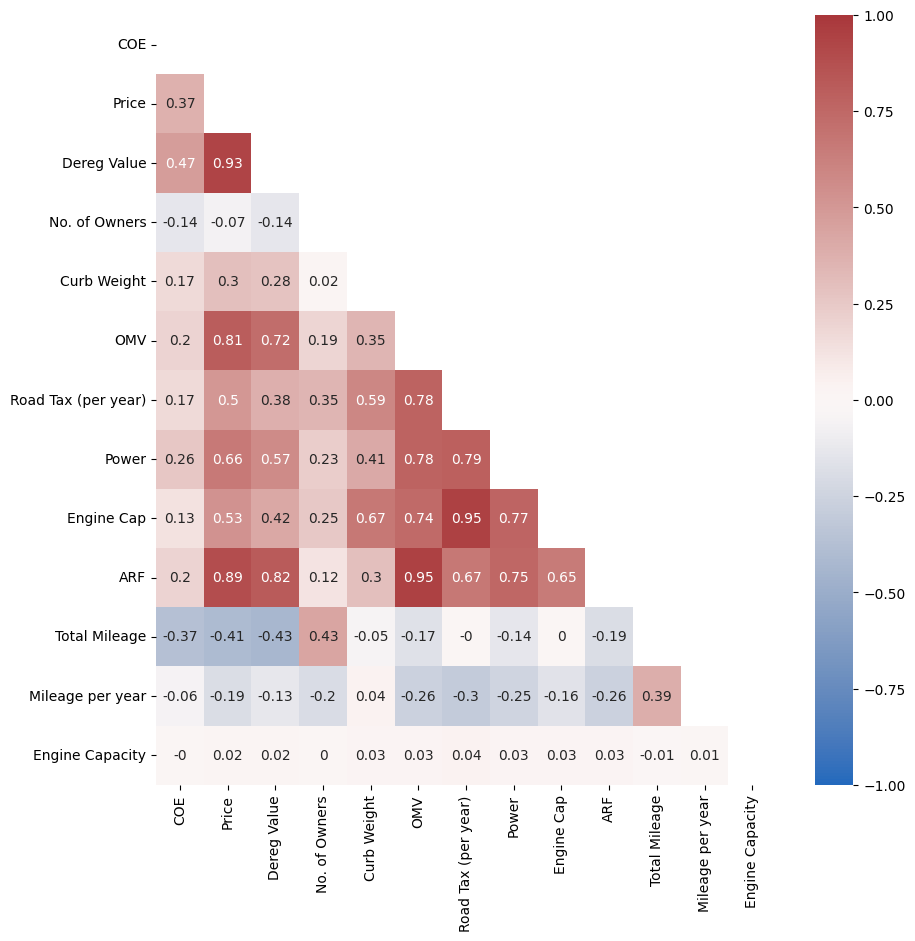

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

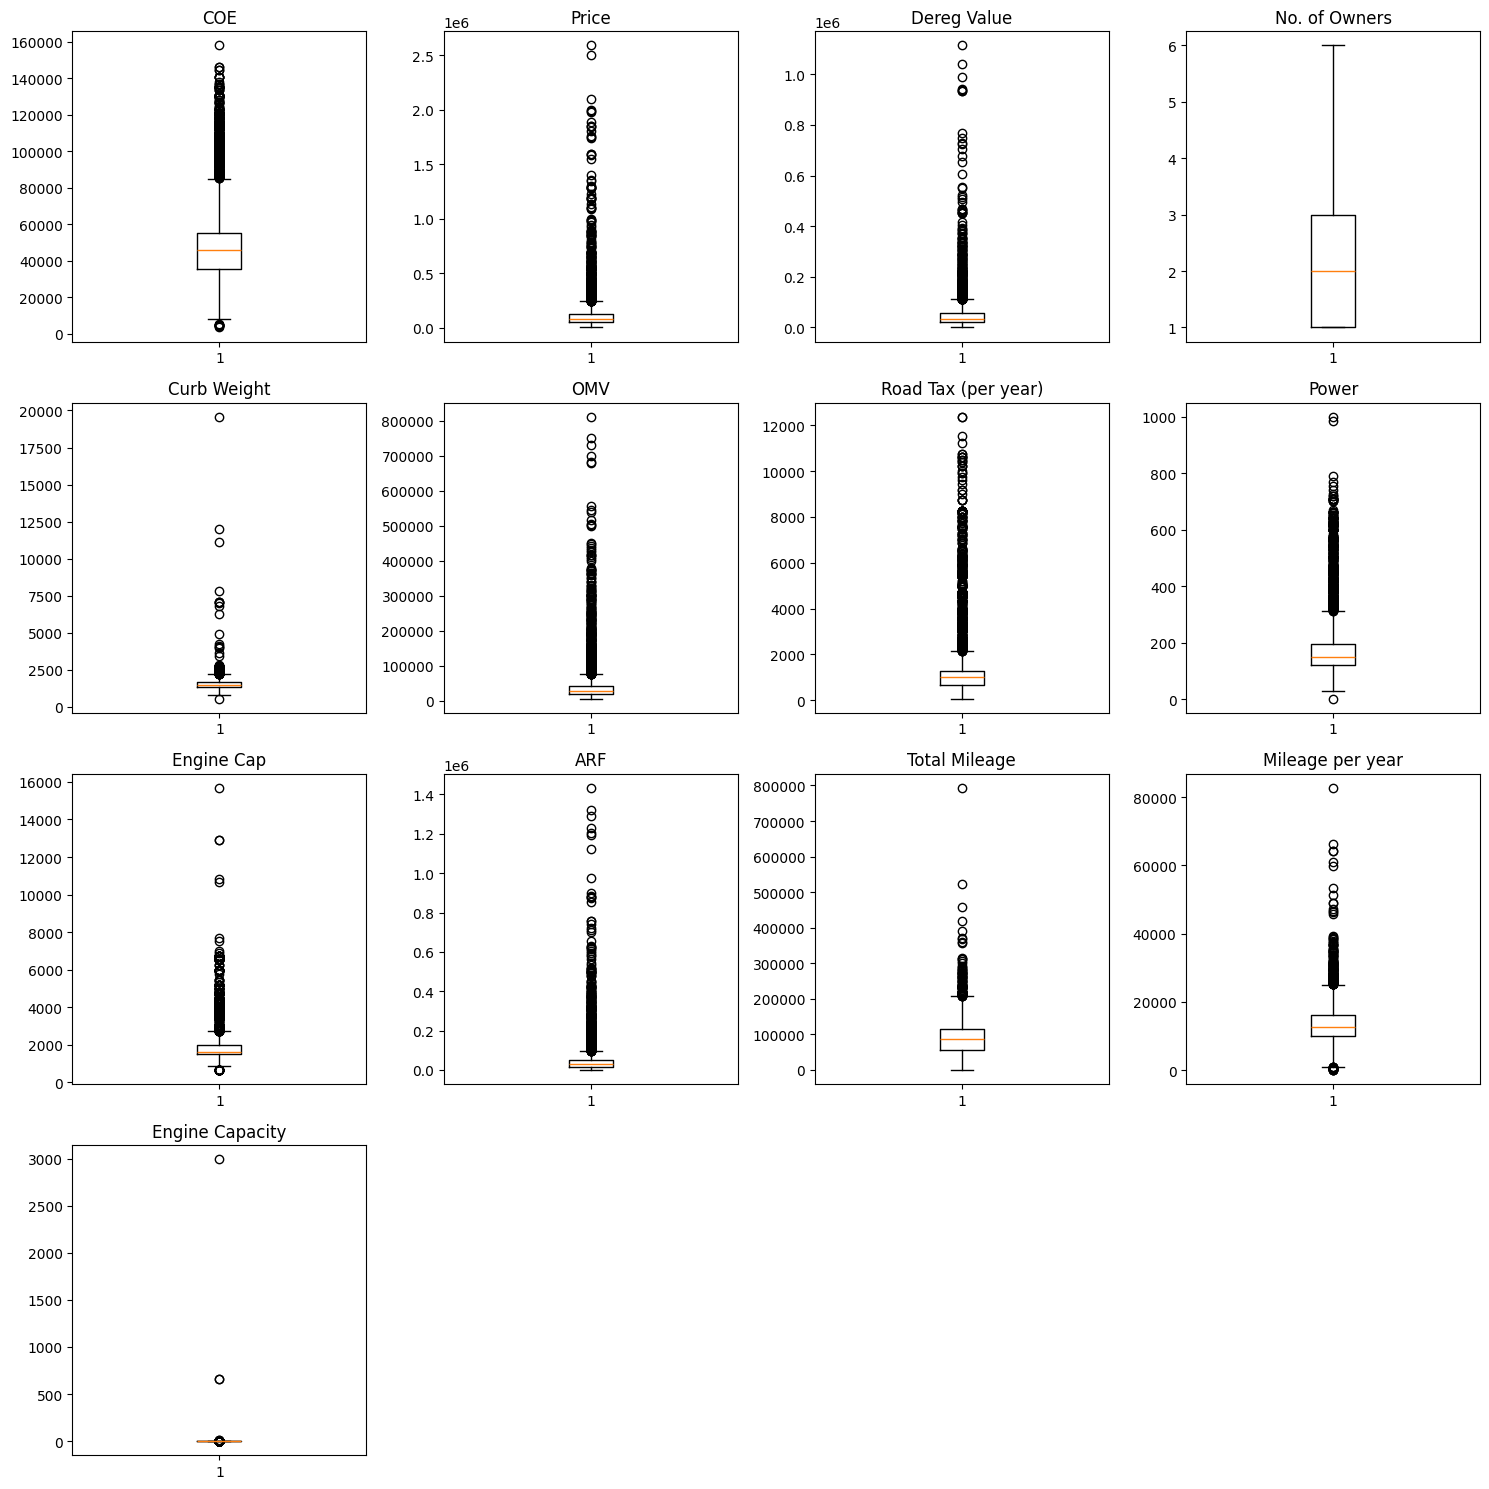

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    axs[i].boxplot(filled_car_data[col].dropna())
    axs[i].set_title(col)

for j in range(len(numeric_cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [20]:
# It can be seen that mainstream models account for the vast majority. We eliminate outliers with less data.

filled_car_data['Car Brand'].value_counts().sum()

7436

In [21]:
brands = filled_car_data['Car Brand'].value_counts()[:10].index.tolist()

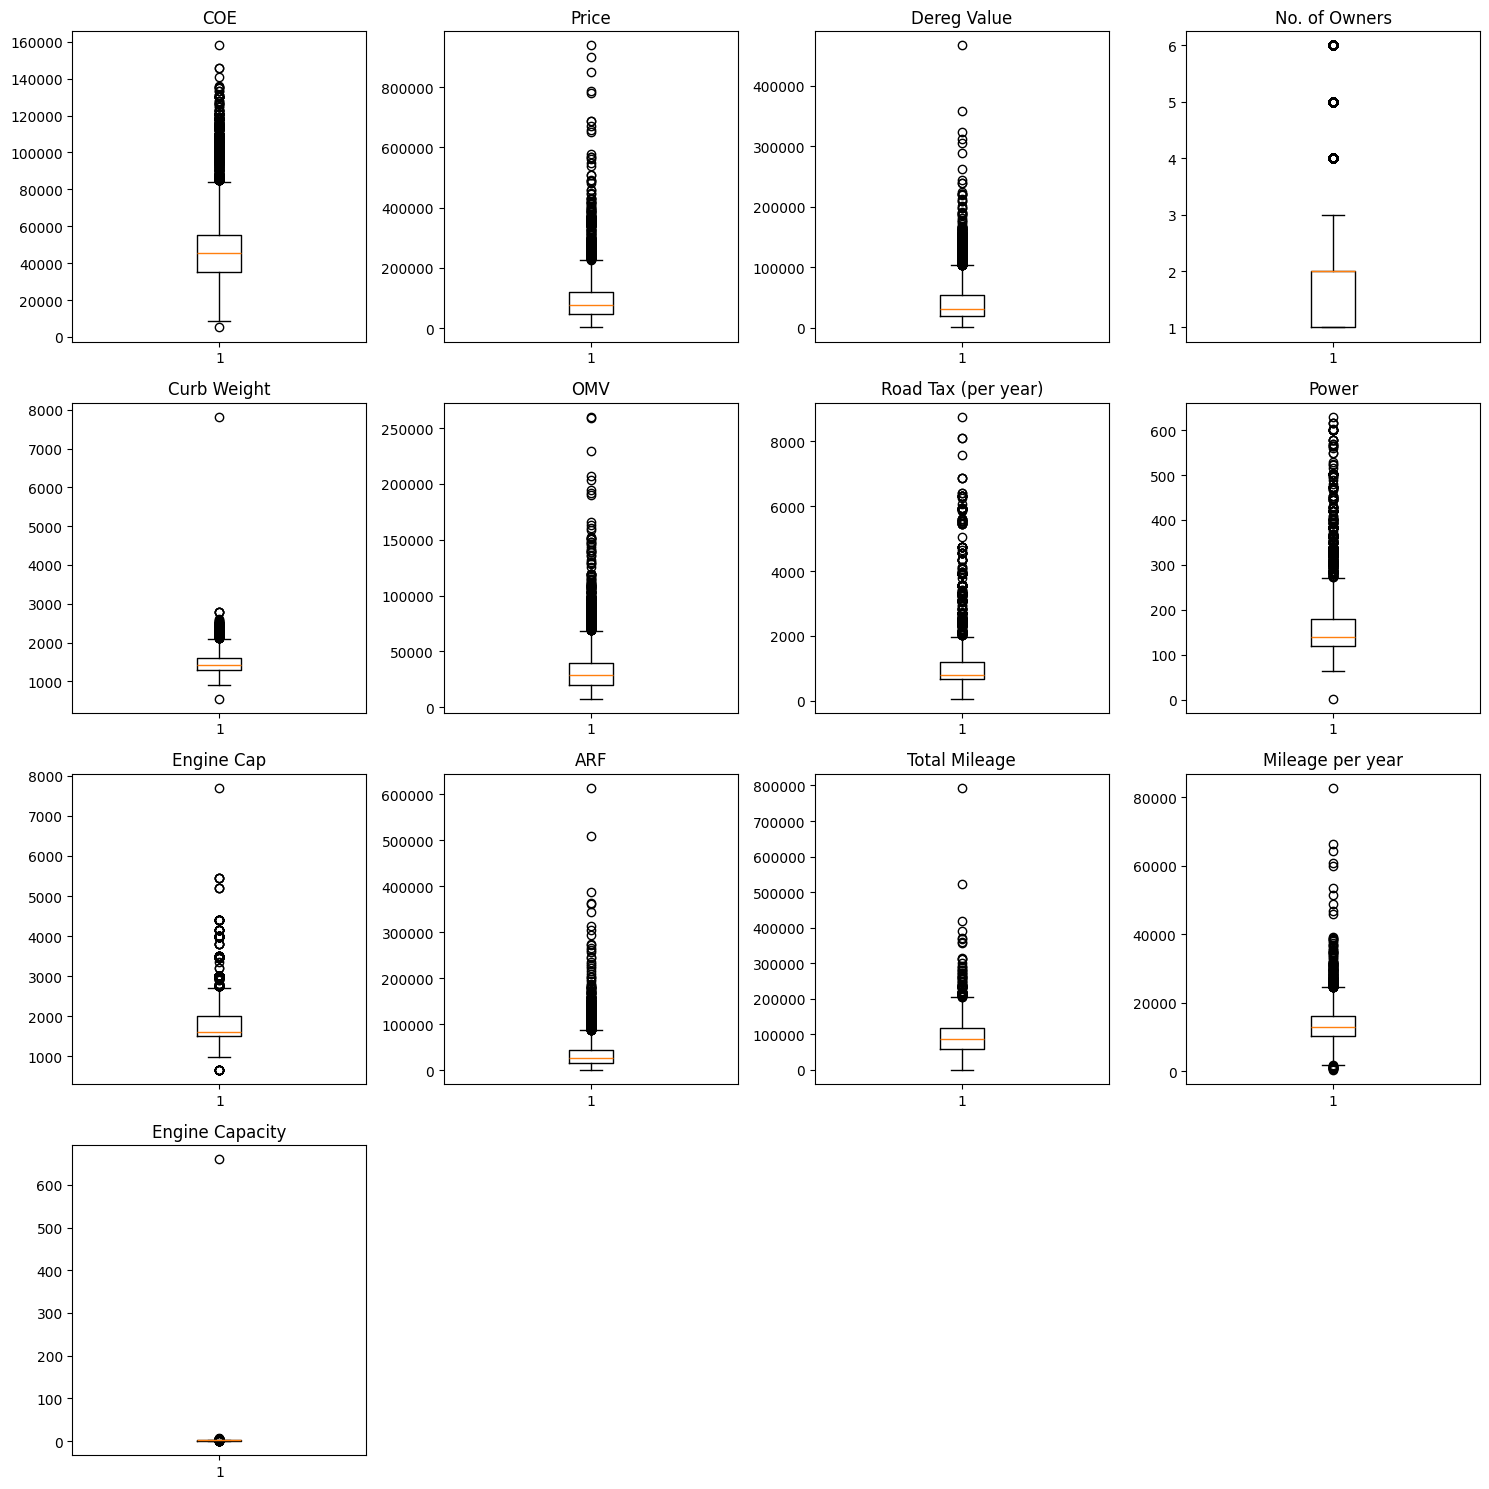

In [22]:
filled_car_data2= filled_car_data[filled_car_data['Car Brand'].isin(brands)]

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    axs[i].boxplot(filled_car_data2[col].dropna())
    axs[i].set_title(col)

for j in range(len(numeric_cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

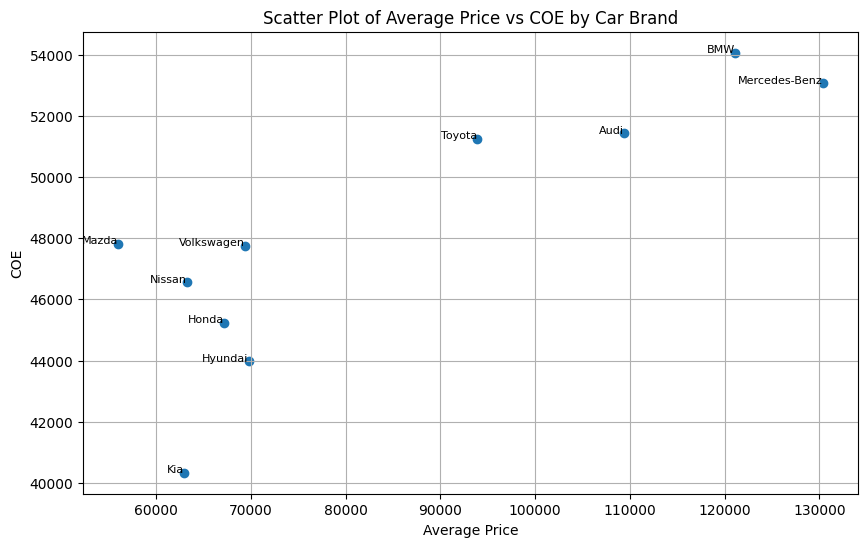

In [24]:
grouped_data = filled_car_data2.groupby('Car Brand')[['Price', 'COE']].mean()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(grouped_data['Price'], grouped_data['COE'])

# Add labels and title
for brand, (x, y) in grouped_data.iterrows():
    plt.text(x, y, brand, fontsize=8, ha='right')  # Annotate each point with the car brand

plt.xlabel('Average Price')
plt.ylabel('COE')
plt.title('Scatter Plot of Average Price vs COE by Car Brand')
plt.grid(True)
plt.show()

<ipython-input-25-5eefef82c3e3>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_counts = filled_car_data.groupby(['Fuel Type', 'Price Bin']).size().unstack(fill_value=0)


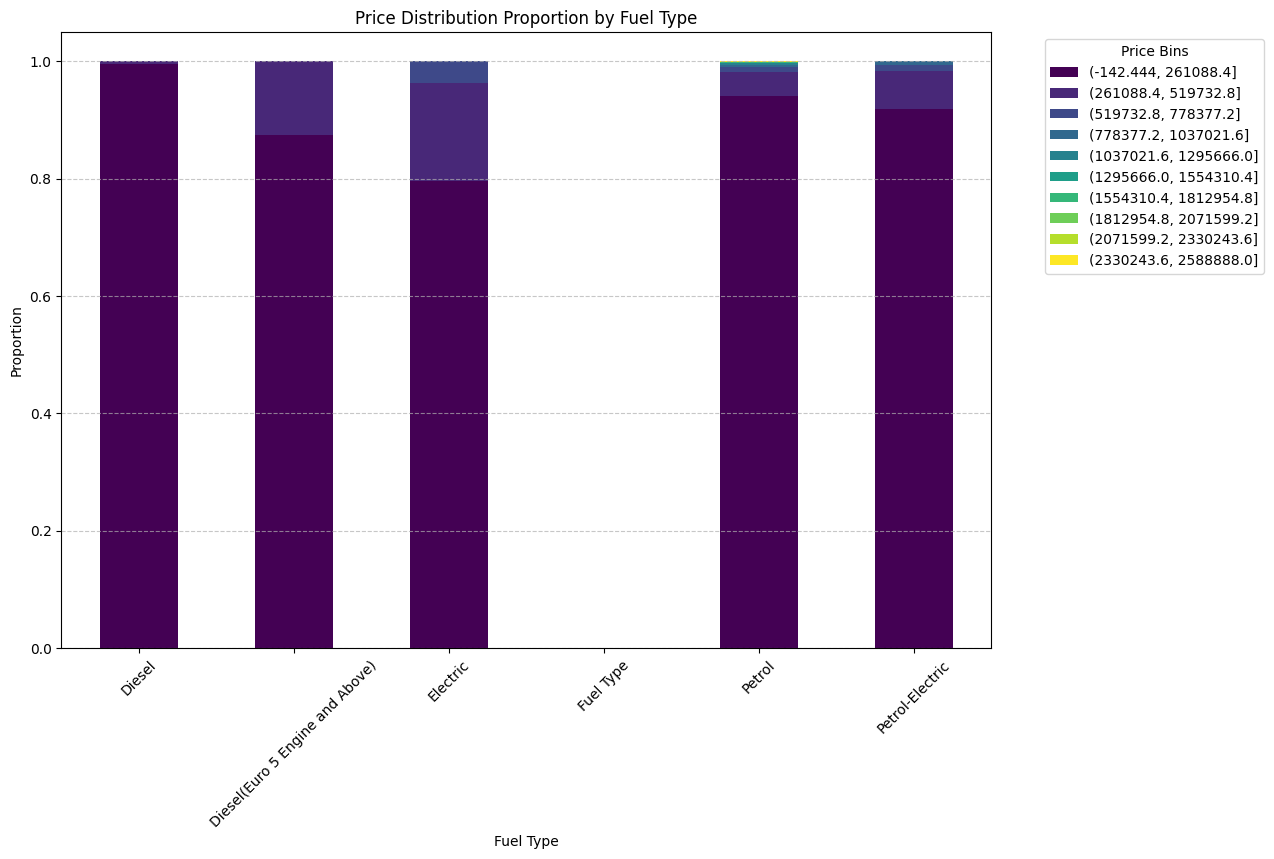

In [25]:
price_bins = pd.cut(filled_car_data['Price'], bins=10)  # Adjust number of bins as needed

filled_car_data['Price Bin'] = price_bins

price_counts = filled_car_data.groupby(['Fuel Type', 'Price Bin']).size().unstack(fill_value=0)

price_proportions = price_counts.div(price_counts.sum(axis=1), axis=0)

price_proportions.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')

plt.xlabel('Fuel Type')
plt.ylabel('Proportion')
plt.title('Price Distribution Proportion by Fuel Type')
plt.legend(title='Price Bins', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


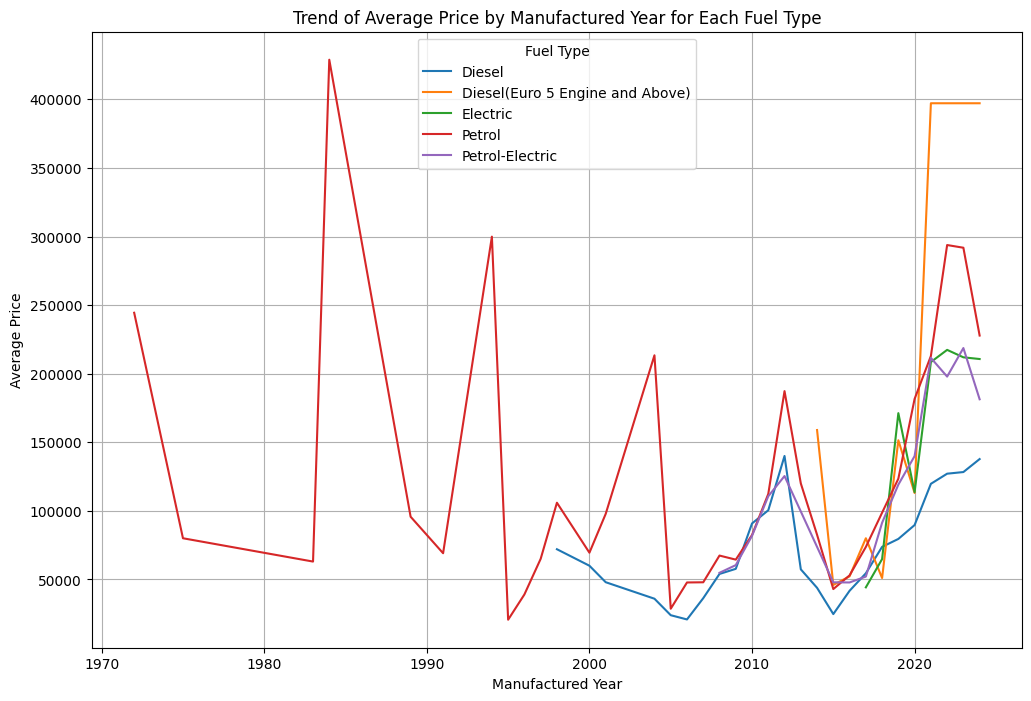

In [26]:
filled_car_data['Manufactured'] = pd.to_datetime(filled_car_data['Manufactured'], errors='coerce')

price_trend = filled_car_data.groupby(['Manufactured', 'Fuel Type'])['Price'].mean().reset_index()

price_trend_pivot = price_trend.pivot(index='Manufactured', columns='Fuel Type', values='Price')

price_trend_pivot = price_trend_pivot.interpolate(method='linear')

plt.figure(figsize=(12, 8))
for fuel_type in price_trend_pivot.columns:
    plt.plot(price_trend_pivot.index, price_trend_pivot[fuel_type], label=fuel_type)

plt.xlabel('Manufactured Year')
plt.ylabel('Average Price')
plt.title('Trend of Average Price by Manufactured Year for Each Fuel Type')
plt.legend(title='Fuel Type')
plt.grid(True)
plt.show()


# Model Training and Evaluation




This code performs the following steps for predicting car prices using various machine learning models:

1. **Data Preprocessing For Model**:
   - Loads the necessary columns from the dataset and drops any rows with missing values.
   - Transforms and encodes categorical variables using `LabelEncoder`.
   - Creates new features, such as car age and logarithmic transformations of COE and deregistered value.
   - Splits the dataset into features (X) and target variable (y), followed by a train-test split.

2. **Model Definitions**:
   - Defines multiple regression models including Random Forest, XGBoost, CatBoost, LightGBM, Gradient Boosting, and a Multi-Layer Perceptron (MLP).
   - Implements a grid search to find the best parameters for the XGBoost model.

3. **Model Training and Evaluation**:
   - Trains each model on the training dataset.
   - Evaluates the models using RMSE, MAE, and R² metrics on the test dataset.
   - Stores and prints the results for each model.

4. **Visualization**:
   - Visualizes the performance of each model using bar plots for RMSE, MAE, and R².
   - Plots the training and validation loss for the MLP model to assess its learning process.

The objective is to compare the performance of different regression models in predicting car prices and identify the most effective model based on the evaluation metrics.

In [27]:
file_path = '/content/drive/MyDrive/IS5126_final/filled_car_data.csv'

filled_car_data = pd.read_csv(file_path, dtype={'Category_Multilabel': str})

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Training CatBoost...
CatBoost - RMSE: 40327.3243361479, MAE: 13055.509425031933, R^2: 0.9031834038128735
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 5384, number of used features: 16
[LightGBM] [Info] Start training from score 99035.883730
LightGBM - RMSE: 43791.079274897296, MAE: 13270.439737316345, R^2: 0.8858378099326182
Training Gradient Boosting...
Gradient Boosting - RMSE: 31802.708486059953, MAE: 12790.115120849547, R^2: 0.9397885327353594
Training Random Forest...
Random Forest - RMSE: 35975.180600787484, MAE: 12933.810772659734, R^2: 0.9229527824525756
Training XGBoost (Best Params)...
XGBoost (Best Params) - RMSE: 39173.302788024914, MAE: 13263.758128819458, R^2: 0.9086451997035964
Trai

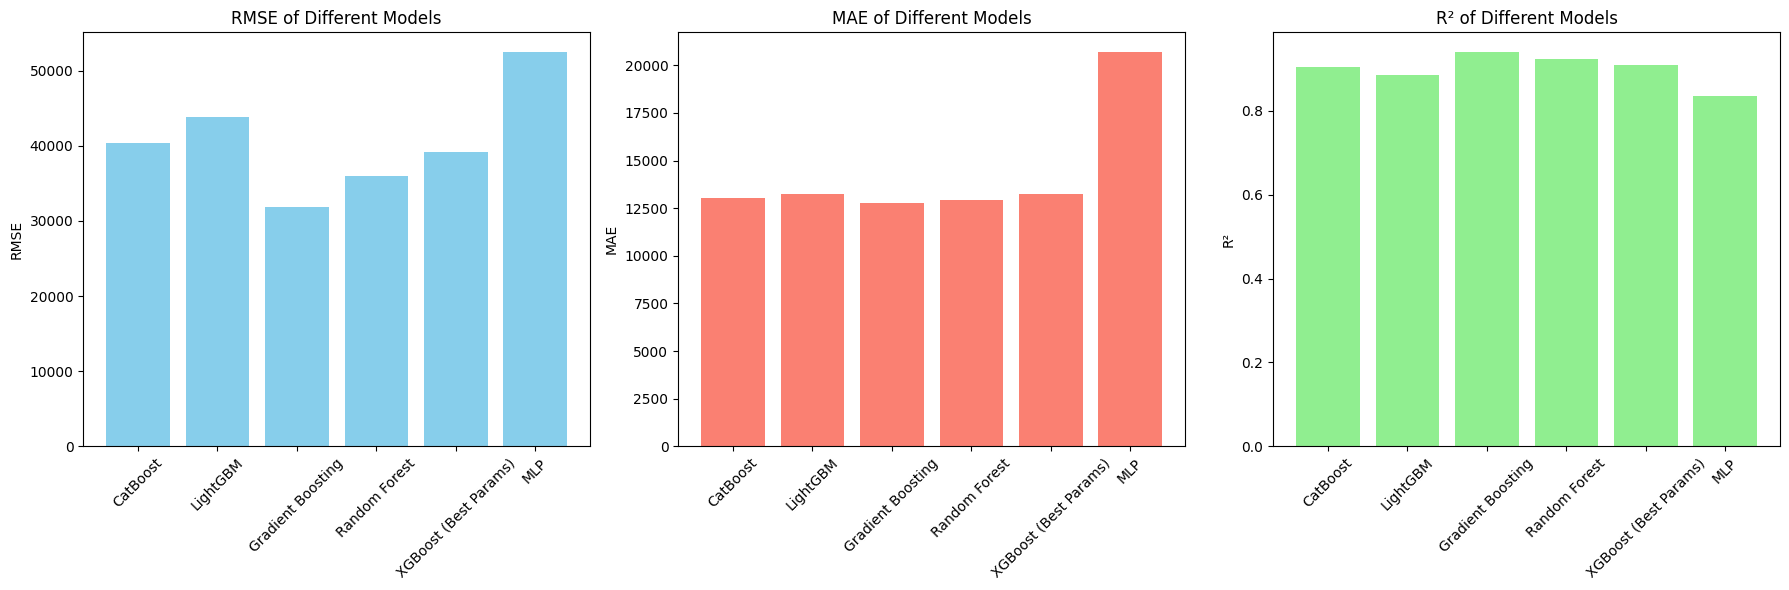

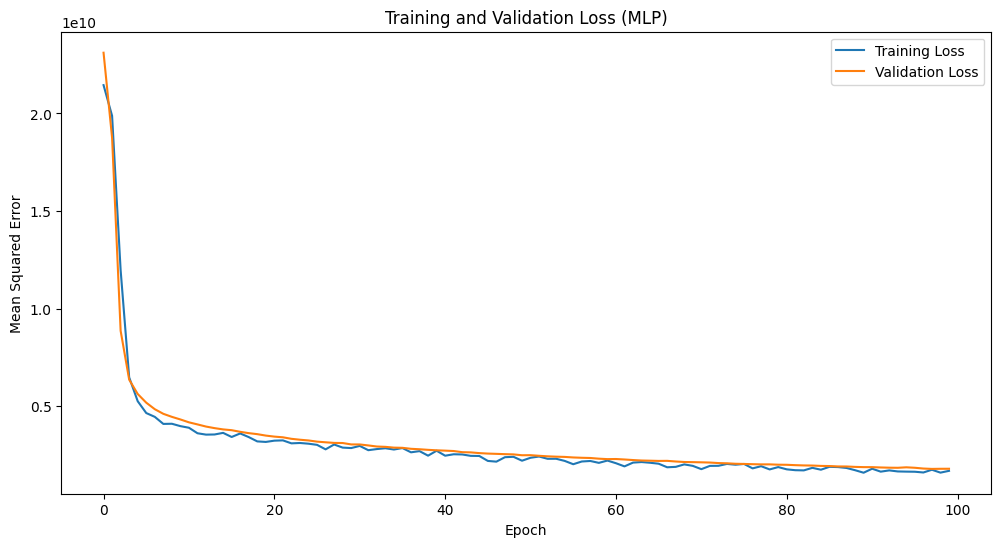

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Step 1: Data preprocessing
columns_needed = [
    'Car Brand', 'Car Model', 'COE', 'Price', 'Dereg Value', 'Manufactured',
    'No. of Owners', 'Mileage per year', 'Engine Capacity', 'Engine Type',
    'Category_Multilabel', 'Sentiment_Score', 'Avg_Word_Sentiment',
    'Word_Count', 'Adjective_Count', 'Sentence_Length', 'Stop_Word_Count'
]
model_car_data = filled_car_data[columns_needed]
model_car_data.dropna(inplace=True)

# Feature engineering
model_car_data['Manufactured'] = pd.to_numeric(model_car_data['Manufactured'], errors='coerce')
model_car_data['Dereg Value'] = model_car_data['Dereg Value'].replace(r'[^\d.]+', '', regex=True).astype(float)
model_car_data['No. of Owners'] = pd.to_numeric(model_car_data['No. of Owners'], errors='coerce')
model_car_data['Engine Capacity'] = model_car_data['Engine Capacity'].replace(r'[^\d.]', '', regex=True).astype(float)
model_car_data['No. of Owners'].fillna(model_car_data['No. of Owners'].median(), inplace=True)

# Create car age feature and log transformation
current_year = 2024
model_car_data['Car_Age'] = current_year - model_car_data['Manufactured']
model_car_data['Log_COE'] = np.log1p(model_car_data['COE'])
model_car_data['Log_Dereg_Value'] = np.log1p(model_car_data['Dereg Value'])
model_car_data['Log_Mileage_per_year'] = np.log1p(model_car_data['Mileage per year'])

# Encode categorical variables
categorical_columns = ['Car Brand', 'Car Model', 'Engine Type', 'Category_Multilabel']
for col in categorical_columns:
    model_car_data[col] = LabelEncoder().fit_transform(model_car_data[col].astype(str))

# Remove unnecessary columns
model_car_data.drop(columns=['Manufactured', 'COE', 'Dereg Value', 'Mileage per year'], inplace=True)

# Split the dataset into features X and target variable y
X = model_car_data.drop('Price', axis=1)
y = model_car_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Store models and their names
models = {
    "CatBoost": CatBoostRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbose=0),
    "LightGBM": lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

# XGBoost parameter search and add the best model
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}
xgb_grid_search = GridSearchCV(XGBRegressor(), param_grid=xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
xgb_grid_search.fit(X_train, y_train)
models["XGBoost (Best Params)"] = xgb_grid_search.best_estimator_

# MLP model
def build_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'R^2': r2}
    print(f"{model_name} - RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

# Train and evaluate MLP model
print("Training MLP...")
mlp_model = build_mlp_model(X_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = mlp_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
y_pred = mlp_model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
results["MLP"] = {'RMSE': rmse, 'MAE': mae, 'R^2': r2}
print(f"MLP - RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

# Display all model results
results_df = pd.DataFrame(results).T
print("\nComparison of Model Performance:")
print(results_df)

# Visualize the performance of each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. RMSE visualization
axes[0].bar(results_df.index, results_df['RMSE'], color='skyblue')
axes[0].set_title('RMSE of Different Models')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# 2. MAE visualization
axes[1].bar(results_df.index, results_df['MAE'], color='salmon')
axes[1].set_title('MAE of Different Models')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# 3. R² visualization
axes[2].bar(results_df.index, results_df['R^2'], color='lightgreen')
axes[2].set_title('R² of Different Models')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Visualize MLP training process
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss (MLP)')
plt.legend()
plt.show()


## Conclusion Analysis

In the model evaluation, we compared the performance of several regression models including CatBoost, LightGBM, Gradient Boosting, Random Forest, and XGBoost (Best Params), alongside a Multi-Layer Perceptron (MLP). The following key points can be drawn from the results:

1. **Model Performance**:
   - **CatBoost** exhibited the highest RMSE of **40327.32**, indicating that it struggled with prediction accuracy compared to other models.
   - **LightGBM** performed slightly better with an RMSE of **43791.08**, but still showed significant prediction errors.
   - **Gradient Boosting** provided a more balanced performance with an RMSE of **31802.71**, suggesting it may be more suitable for this dataset.
   - **Random Forest** displayed an RMSE of **35975.18**, which is moderate and comparable to the performance of XGBoost with its best parameters (**39173.30**).
   - The **MLP** model had the poorest performance with an RMSE of **51334.55**, indicating it may not be the best choice for this specific regression task.

2. **Mean Absolute Error (MAE)**:
   - The MAE results reflect a similar trend, with Gradient Boosting having the lowest MAE (**12790.11**), followed closely by Random Forest (**12933.81**) and XGBoost (**13263.76**).
   - CatBoost and LightGBM also displayed higher MAEs, indicating larger average errors in their predictions.

3. **R² Scores**:
   - The R² score provides insight into how well the models capture variance in the data.
   - **Gradient Boosting** and **Random Forest** achieved R² scores around **0.94**, showcasing their ability to explain a significant proportion of the variance in the target variable.
   - Both **CatBoost** and **LightGBM** scored lower, suggesting that while they made predictions, they did not explain the variance as effectively as Gradient Boosting and Random Forest.
   - The MLP model had an R² of **0.84**, confirming its inferior performance in this analysis.

4. **Conclusion**:
   - Based on the performance metrics, **XGBoost** and **Random Forest** are recommended for further refinement and deployment. Their balance of RMSE, MAE, and R² suggests they are well-suited for the task at hand.
   - It is suggested to implement a voting ensemble using both XGBoost and Random Forest to potentially improve the predictive performance and robustness of the model.
   - Additionally, further investigation into data preprocessing steps or feature engineering techniques may enhance the overall model accuracy and reliability in future experiments.


## Model Performance Evaluation

### Comparison of Model Performance

The models evaluated in this study include **Random Forest**, **XGBoost**, and a **Stacking Model**. The following metrics were considered for evaluation: RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R² (Coefficient of Determination).

| Model                    | RMSE         | MAE          | R²         |
|--------------------------|--------------|--------------|------------|
| Random Forest            | 34274.585124  | 12110.180713  | 0.930065   |
| XGBoost (Best Params)   |  36887.436677    | 12163.693604 | 0.918996   |
| Stacking Model           | 33163.200394  | 12155.342982  | 0.934527   |
|Voting Ensemble     |    33019.22472820108 |11333.615887519989|  0.9350940160767485
           

### Conclusion

Based on the evaluation metrics, the **Random Forest** and **Stacking Model** demonstrate superior performance compared to **XGBoost**. The Stacking Model exhibits the lowest RMSE and MAE values, indicating it is the most accurate model among those tested.

### Recommendation
It is recommended to utilize the **Voting Ensemble**, which combines **Random Forest** and **Stacking Model** predictions, for final predictions to leverage the strengths of both models and improve overall accuracy.


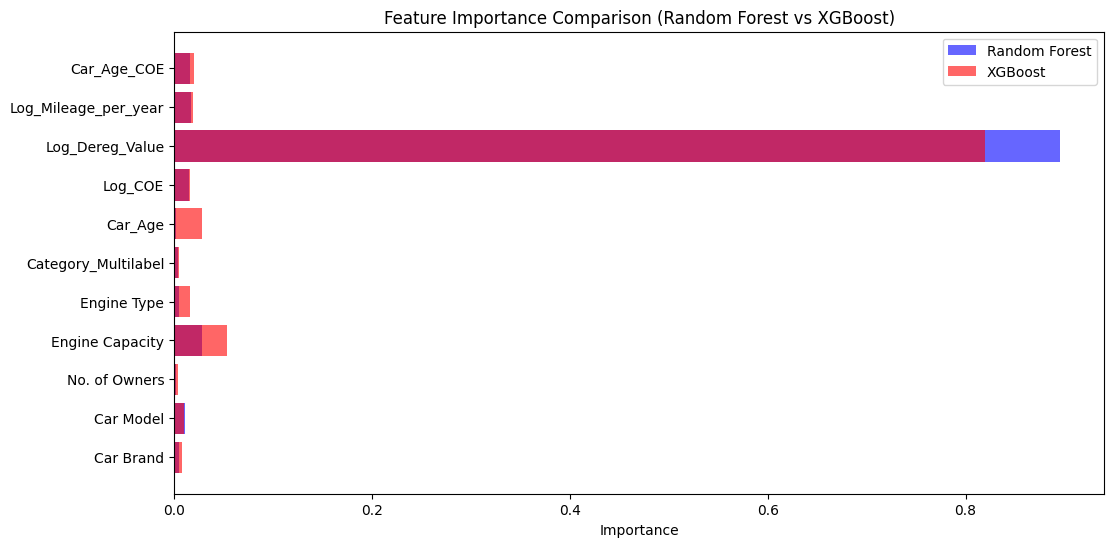

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 5384, number of used features: 11
[LightGBM] [Info] Start training from score 99035.883730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1454
[LightGBM] [Info] Number of data points in the train set: 4307, number of used features: 11
[LightGBM] [Info] Start training from score 97557.194335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train 

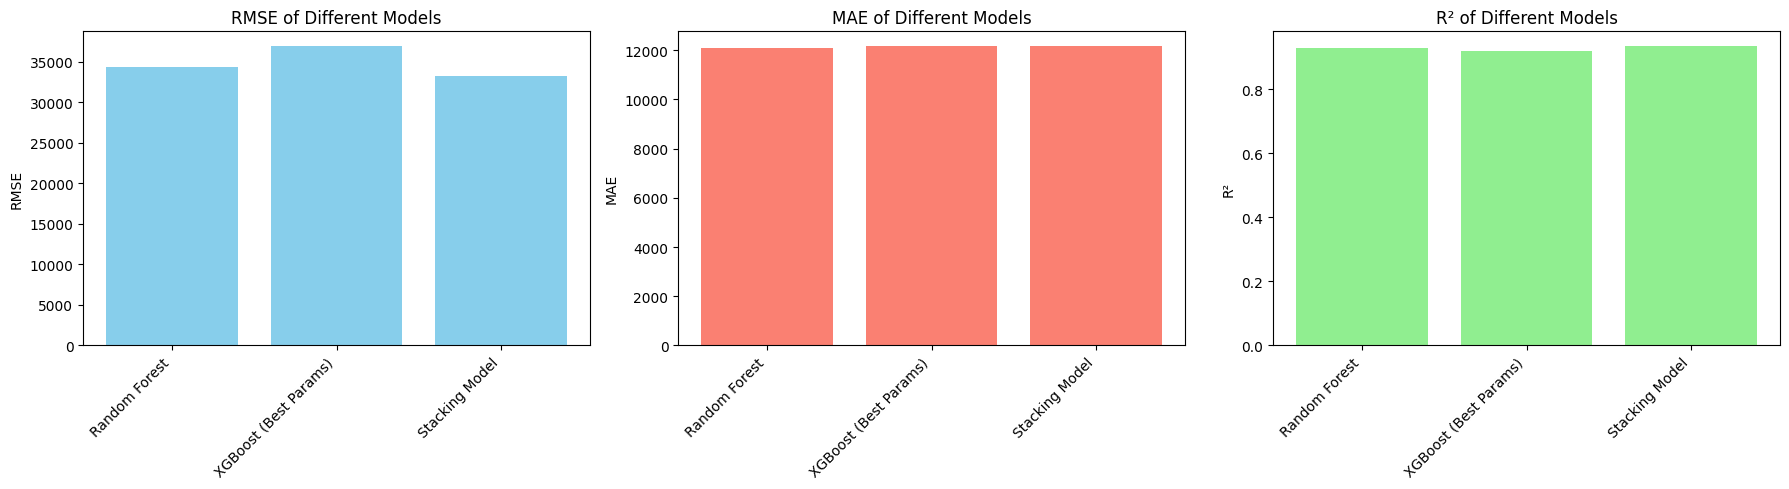

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 5384, number of used features: 11
[LightGBM] [Info] Start training from score 99035.883730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1454
[LightGBM] [Info] Number of data points in the train set: 4307, number of used features: 11
[LightGBM] [Info] Start training from score 97557.194335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train set: 4307, number of used features: 11
[LightGBM] [Info] Star

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

# Step 1: Data preprocessing
columns_needed = [
    'Car Brand', 'Car Model', 'COE', 'Price', 'Dereg Value', 'Manufactured',
    'No. of Owners', 'Mileage per year', 'Engine Capacity', 'Engine Type',
    'Category_Multilabel'
]
model_car_data = filled_car_data[columns_needed]
model_car_data.dropna(inplace=True)

# Feature engineering
model_car_data['Manufactured'] = pd.to_numeric(model_car_data['Manufactured'], errors='coerce')
model_car_data['Dereg Value'] = model_car_data['Dereg Value'].replace(r'[^\d.]+', '', regex=True).astype(float)
model_car_data['No. of Owners'] = pd.to_numeric(model_car_data['No. of Owners'], errors='coerce')
model_car_data['Engine Capacity'] = model_car_data['Engine Capacity'].replace(r'[^\d.]', '', regex=True).astype(float)
model_car_data['No. of Owners'].fillna(model_car_data['No. of Owners'].median(), inplace=True)

# Create car age feature and log transformations
current_year = 2024
model_car_data['Car_Age'] = current_year - model_car_data['Manufactured']
model_car_data['Log_COE'] = np.log1p(model_car_data['COE'])
model_car_data['Log_Dereg_Value'] = np.log1p(model_car_data['Dereg Value'])
model_car_data['Log_Mileage_per_year'] = np.log1p(model_car_data['Mileage per year'])

# Create interaction features
model_car_data['Car_Age_COE'] = model_car_data['Car_Age'] * model_car_data['Log_COE']

# Encode categorical variables
categorical_columns = ['Car Brand', 'Car Model', 'Engine Type', 'Category_Multilabel']
for col in categorical_columns:
    model_car_data[col] = LabelEncoder().fit_transform(model_car_data[col].astype(str))

# Remove unnecessary columns
model_car_data.drop(columns=['Manufactured', 'COE', 'Dereg Value', 'Mileage per year'], inplace=True)

# Split the dataset into features X and target variable y
X = model_car_data.drop('Price', axis=1)
y = model_car_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature importance analysis
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

importances_rf = rf.feature_importances_
importances_xgb = xgb.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(features, importances_rf, color='blue', alpha=0.6, label='Random Forest')
plt.barh(features, importances_xgb, color='red', alpha=0.6, label='XGBoost')
plt.xlabel('Importance')
plt.title('Feature Importance Comparison (Random Forest vs XGBoost)')
plt.legend()
plt.show()

# Advanced hyperparameter optimization
xgb_param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 300),
    'subsample': uniform(0.7, 0.3)
}
xgb_random_search = RandomizedSearchCV(
    XGBRegressor(), param_distributions=xgb_param_dist, n_iter=20, cv=3,
    scoring='neg_mean_squared_error', random_state=42, verbose=1
)
xgb_random_search.fit(X_train, y_train)
best_xgb = xgb_random_search.best_estimator_

# Ensemble Learning - Stacking
estimators = [
    ('catboost', CatBoostRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbose=0)),
    ('lgb', lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42))
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_model.fit(X_train, y_train)

# Evaluate all models
models = {
    "Random Forest": rf,
    "XGBoost (Best Params)": best_xgb,
    "Stacking Model": stacking_model
}

# Store results
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'R^2': r2}
    print(f"{model_name} - RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

# Display results of all models
results_df = pd.DataFrame(results).T
print("\nComparison of Model Performance:")
print(results_df)

# Visualize evaluation metrics for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. RMSE
axes[0].bar(results_df.index, results_df['RMSE'], color='skyblue')
axes[0].set_title('RMSE of Different Models')
axes[0].set_ylabel('RMSE')
axes[0].set_xticklabels(results_df.index, rotation=45, ha="right")

# 2. MAE
axes[1].bar(results_df.index, results_df['MAE'], color='salmon')
axes[1].set_title('MAE of Different Models')
axes[1].set_ylabel('MAE')
axes[1].set_xticklabels(results_df.index, rotation=45, ha="right")

# 3. R²
axes[2].bar(results_df.index, results_df['R^2'], color='lightgreen')
axes[2].set_title('R² of Different Models')
axes[2].set_ylabel('R²')
axes[2].set_xticklabels(results_df.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Voting Ensemble
from sklearn.ensemble import VotingRegressor

# Combine the best performing models
voting_ensemble = VotingRegressor(
    estimators=[
        ('random_forest', rf),
        ('xgboost', best_xgb),
        ('stacking_model', stacking_model)
    ]
)
voting_ensemble.fit(X_train, y_train)

# Evaluate Voting Ensemble
y_pred_voting = voting_ensemble.predict(X_test)
mse_voting = mean_squared_error(y_test, y_pred_voting)
rmse_voting = np.sqrt(mse_voting)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
r2_voting = r2_score(y_test, y_pred_voting)

print(f"Voting Ensemble - RMSE: {rmse_voting}")
print(f"Voting Ensemble - MAE: {mae_voting}")
print(f"Voting Ensemble - R^2: {r2_voting}")


In [39]:
from joblib import dump
from google.colab import files



# Save label_encoders
dump(label_encoders, 'label_encoders.joblib')
print("Label encoders saved.")

# Save scaler
dump(scaler, 'scaler.joblib')
print("Scaler saved.")

# Save Voting Ensemble model
dump(voting_ensemble, 'voting_ensemble_model.joblib')
print("Voting Ensemble model saved.")

# download
print("Downloading files...")
files.download('label_encoders.joblib')
files.download('scaler.joblib')
files.download('voting_ensemble_model.joblib')
print("Files downloaded.")


Label encoders saved.
Scaler saved.
Voting Ensemble model saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded.


In [40]:
from joblib import load

label_encoders = load('label_encoders.joblib')

scaler = load('scaler.joblib')

voting_ensemble = load('voting_ensemble_model.joblib')


Test case of calling model

In [41]:
def predict_with_ensemble(test_data, label_encoders, scaler, voting_ensemble, current_year=2024):

    necessary_columns = ['Manufactured', 'Dereg Value', 'No. of Owners', 'Engine Capacity']
    for col in necessary_columns:
        if col not in test_data.columns:
            raise ValueError(f"Missing necessary column in input data: {col}")

    test_data['Manufactured'] = pd.to_numeric(test_data['Manufactured'], errors='coerce')
    test_data['Dereg Value'] = test_data['Dereg Value'].replace(r'[^\d.]+', '', regex=True).astype(float)
    test_data['No. of Owners'] = pd.to_numeric(test_data['No. of Owners'], errors='coerce')
    test_data['Engine Capacity'] = test_data['Engine Capacity'].replace(r'[^\d.]', '', regex=True).astype(float)
    test_data['Car_Age'] = current_year - test_data['Manufactured']
    test_data['Log_COE'] = np.log1p(test_data['COE'])
    test_data['Log_Dereg_Value'] = np.log1p(test_data['Dereg Value'])
    test_data['Log_Mileage_per_year'] = np.log1p(test_data['Mileage per year'])
    test_data['Car_Age_COE'] = test_data['Car_Age'] * test_data['Log_COE']

    for col in label_encoders:
        test_data[col] = label_encoders[col].transform(test_data[col].astype(str))

    features = [col for col in test_data.columns if col in label_encoders or col in ['Car_Age', 'Log_COE', 'Log_Dereg_Value', 'Log_Mileage_per_year', 'Car_Age_COE', 'Engine Capacity', 'No. of Owners']]
    test_data = test_data[features]

    test_data_scaled = scaler.transform(test_data)

    prediction = voting_ensemble.predict(test_data_scaled)
    return prediction

# load listing
label_encoders = load('label_encoders.joblib')
scaler = load('scaler.joblib')
voting_ensemble = load('voting_ensemble_model.joblib')


test_data = filled_car_data.iloc[3:4].copy()
prediction = predict_with_ensemble(test_data, label_encoders, scaler, voting_ensemble)
print(f"Sample Test Voting Ensemble Prediction: {prediction[0]}")


Sample Test Voting Ensemble Prediction: 1299004.3583827903
